In [1]:
# Import necessary libraries for file handling, data manipulation, and visualization
import os 
import random
import numpy as np 
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt

# Import libraries for working with images and transformations
from PIL import Image
import cv2 as cv

# Import PyTorch modules for model building, data handling, and evaluation
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

# Import libraries for machine learning metrics and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import torchmetrics
from tqdm import tqdm

In [3]:
data_dir = "C:\\Users\\sebastian.cruz6\\Workspace\\Research\\CAWT-URFI\\cp-anemia-detection\\data\\cp-anemia\\"
anemic_dir = data_dir+"Anemic\\"
non_anemic_dir = data_dir+"Non-anemic\\"

data_sheet_path = data_dir+"Anemia_Data_Collection_Sheet.csv"
data_sheet = pd.read_csv(data_sheet_path)
display(data_sheet)

,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY
0,Image_001,9.80,Moderate,6,Female,Anemic,Nkawie-Toase Government Hospital,Nkawie-Toase,Atwima Nwabiagya South,Ashanti,Ghana
1,Image_002,9.90,Moderate,24,Male,Anemic,Ejusu Government Hospital,Ejusu,Ejusu Municipality,Ashanti,Ghana
2,Image_003,11.10,Non-Anemic,24,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
3,Image_004,12.50,Non-Anemic,12,Male,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
4,Image_005,9.90,Moderate,24,Male,Anemic,Sunyani Municipal Hospital,Sunyani,Sunyani Municipality,Bono,Ghana
...,...,...,...,...,...,...,...,...,...,...,...
705,Image_706,12.80,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana
706,Image_707,11.47,Non-Anemic,48,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana
707,Image_708,11.60,Non-Anemic,60,Male,Non-anemic,Komfo Anokye Teaching Hospital,Kumasi,Kumasi Metropolitan,Ashanti,Ghana
708,Image_709,12.10,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana


In [4]:
# Mapping diagnosis to severity
severity_mapping = {
    "Non-Anemic": [1,0,0,0],
    "Mild": [0,1,0,0],
    "Moderate": [0,0,1,0],
    "Severe": [0,0,0,1],
}

data_sheet['SEVERITY_ONEHOT'] = data_sheet['Severity'].map(severity_mapping)
display(data_sheet)

,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY,SEVERITY_ONEHOT
0,Image_001,9.80,Moderate,6,Female,Anemic,Nkawie-Toase Government Hospital,Nkawie-Toase,Atwima Nwabiagya South,Ashanti,Ghana,"[0, 0, 1, 0]"
1,Image_002,9.90,Moderate,24,Male,Anemic,Ejusu Government Hospital,Ejusu,Ejusu Municipality,Ashanti,Ghana,"[0, 0, 1, 0]"
2,Image_003,11.10,Non-Anemic,24,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]"
3,Image_004,12.50,Non-Anemic,12,Male,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]"
4,Image_005,9.90,Moderate,24,Male,Anemic,Sunyani Municipal Hospital,Sunyani,Sunyani Municipality,Bono,Ghana,"[0, 0, 1, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
705,Image_706,12.80,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]"
706,Image_707,11.47,Non-Anemic,48,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]"
707,Image_708,11.60,Non-Anemic,60,Male,Non-anemic,Komfo Anokye Teaching Hospital,Kumasi,Kumasi Metropolitan,Ashanti,Ghana,"[1, 0, 0, 0]"
708,Image_709,12.10,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]"


In [5]:
# Mapping diagnosis to severity
remark_mapping = {
    "Non-anemic": 0,
    "Anemic": 1
}

data_sheet['REMARK_ONEHOT'] = data_sheet['REMARK'].map(remark_mapping)
display(data_sheet)

,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY,SEVERITY_ONEHOT,REMARK_ONEHOT
0,Image_001,9.80,Moderate,6,Female,Anemic,Nkawie-Toase Government Hospital,Nkawie-Toase,Atwima Nwabiagya South,Ashanti,Ghana,"[0, 0, 1, 0]",1
1,Image_002,9.90,Moderate,24,Male,Anemic,Ejusu Government Hospital,Ejusu,Ejusu Municipality,Ashanti,Ghana,"[0, 0, 1, 0]",1
2,Image_003,11.10,Non-Anemic,24,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
3,Image_004,12.50,Non-Anemic,12,Male,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
4,Image_005,9.90,Moderate,24,Male,Anemic,Sunyani Municipal Hospital,Sunyani,Sunyani Municipality,Bono,Ghana,"[0, 0, 1, 0]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,Image_706,12.80,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]",0
706,Image_707,11.47,Non-Anemic,48,Female,Non-anemic,Ahmadiyya Muslim Hospital,Tachiman,Techiman Municipality,Bono-East,Ghana,"[1, 0, 0, 0]",0
707,Image_708,11.60,Non-Anemic,60,Male,Non-anemic,Komfo Anokye Teaching Hospital,Kumasi,Kumasi Metropolitan,Ashanti,Ghana,"[1, 0, 0, 0]",0
708,Image_709,12.10,Non-Anemic,48,Male,Non-anemic,Bolgatanga Regional Hospital,Bolgatanga,Bolgatanga Municipality,Upper East,Ghana,"[1, 0, 0, 0]",0


In [6]:
data_sheet.describe(include="all")

,IMAGE_ID,HB_LEVEL,Severity,Age(Months),GENDER,REMARK,HOSPITAL,CITY/TOWN,MUNICIPALITY/DISTRICT,REGION,COUNTRY,SEVERITY_ONEHOT,REMARK_ONEHOT
count,710,710.000000,710,710.000000,710,710,710,710,710,710,710,710,710.000000
unique,710,NaN,4,NaN,2,2,10,8,8,4,1,4,NaN
top,Image_001,NaN,Non-Anemic,NaN,Male,Anemic,Komfo Anokye Teaching Hospital,Kumasi,Kumasi Metropolitan,Ashanti,Ghana,"[1, 0, 0, 0]",NaN
freq,1,NaN,286,NaN,404,424,134,177,177,304,710,286,NaN
mean,NaN,10.358521,NaN,31.587324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.597183
std,NaN,2.258663,NaN,16.783786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.490810
min,NaN,3.100000,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,8.900000,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,10.300000,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,12.100000,NaN,48.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


In [7]:
data_sheet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   IMAGE_ID               710 non-null    object 
 1   HB_LEVEL               710 non-null    float64
 2   Severity               710 non-null    object 
 3   Age(Months)            710 non-null    int64  
 4   GENDER                 710 non-null    object 
 5   REMARK                 710 non-null    object 
 6   HOSPITAL               710 non-null    object 
 7   CITY/TOWN              710 non-null    object 
 8   MUNICIPALITY/DISTRICT  710 non-null    object 
 9   REGION                 710 non-null    object 
 10  COUNTRY                710 non-null    object 
 11  SEVERITY_ONEHOT        710 non-null    object 
 12  REMARK_ONEHOT          710 non-null    int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 72.2+ KB


Severity
Non-Anemic    286
Moderate      232
Mild          144
Severe         48
Name: count, dtype: int64


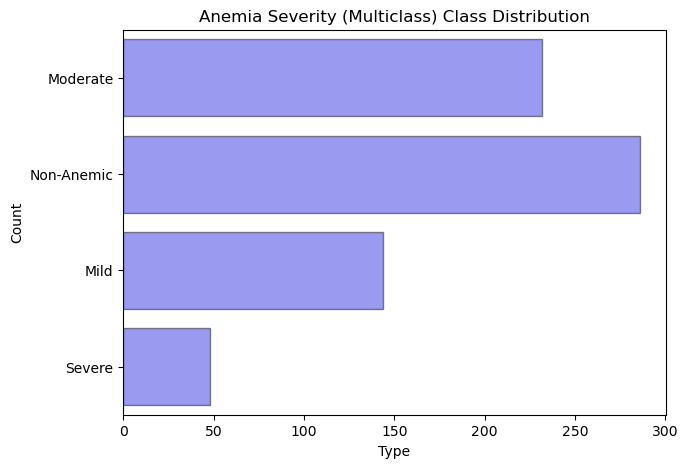

In [8]:
severity_counts = data_sheet['Severity'].value_counts()
print(severity_counts)

plt.figure(figsize=(7, 5))
sns.countplot(data=data_sheet['Severity'], edgecolor='k', color='b', alpha=0.45)
plt.title('Anemia Severity (Multiclass) Class Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

REMARK
Anemic        424
Non-anemic    286
Name: count, dtype: int64


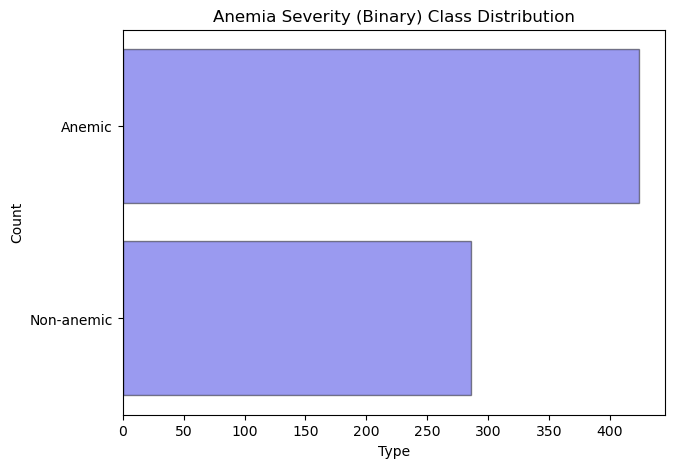

In [9]:
remark_counts = data_sheet['REMARK'].value_counts()
print(remark_counts)

plt.figure(figsize=(7, 5))
sns.countplot(data=data_sheet['REMARK'], edgecolor='k', color='b', alpha=0.45)
plt.title('Anemia Severity (Binary) Class Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

HB_LEVEL
10.20    23
10.10    21
10.00    19
9.60     18
9.90     16
         ..
5.80      1
8.06      1
11.16     1
11.72     1
11.47     1
Name: count, Length: 128, dtype: int64


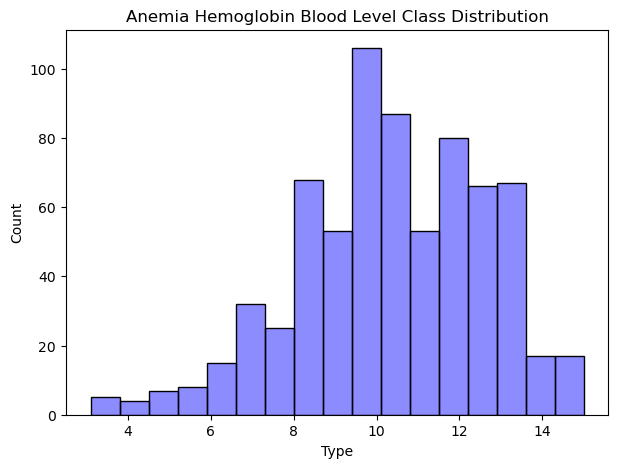

In [10]:
hblevel_counts = data_sheet['HB_LEVEL'].value_counts()
print(hblevel_counts)

plt.figure(figsize=(7, 5))
sns.histplot(data=data_sheet['HB_LEVEL'], edgecolor='k', color='b', alpha=0.45)
plt.title('Anemia Hemoglobin Blood Level Class Distribution')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

Age(Months)
12    180
24    154
36    137
48    126
60     90
6       5
9       5
8       4
11      3
7       3
10      3
Name: count, dtype: int64


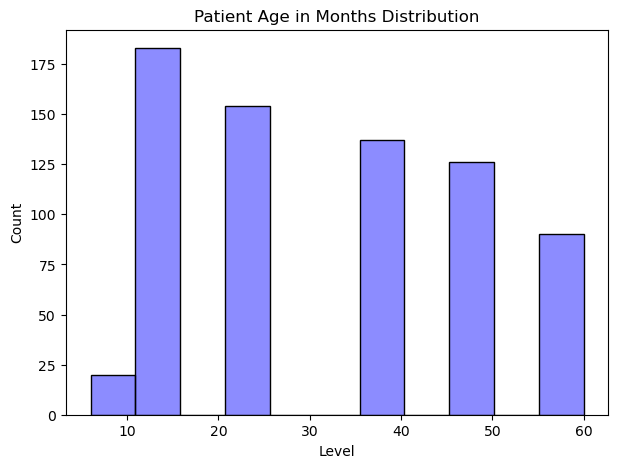

In [11]:
age_counts = data_sheet['Age(Months)'].value_counts()
print(age_counts)

plt.figure(figsize=(7, 5))
sns.histplot(data=data_sheet['Age(Months)'], edgecolor='k', color='b', alpha=0.45)
plt.title('Patient Age in Months Distribution')
plt.xlabel('Level')
plt.ylabel('Count')
plt.show()

GENDER
Male      404
Female    306
Name: count, dtype: int64


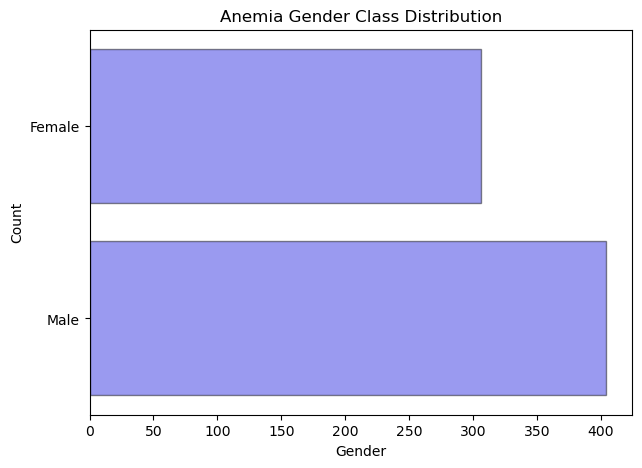

In [12]:
gender_counts = data_sheet['GENDER'].value_counts()
print(gender_counts)

plt.figure(figsize=(7, 5))
sns.countplot(data=data_sheet['GENDER'], edgecolor='k', color='b', alpha=0.45)
plt.title('Anemia Gender Class Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

In [13]:
def load_images(dir, df):
    images = []
    labels = []
    descriptions = []

    for i, row in df.iterrows():
        img_id = row['IMAGE_ID']
        label = row['REMARK']
        desc = row['Severity']
        img_path = dir+label+"/"+img_id+".png"

        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
        img = cv.resize(img, (256,192))  # Resize image to (224, 224)
        images.append(img)
        labels.append(label)
        descriptions.append(desc)
        
    return np.array(images), np.array(labels), np.array(descriptions)

train_images, train_labels, train_categories = load_images(data_dir, data_sheet)

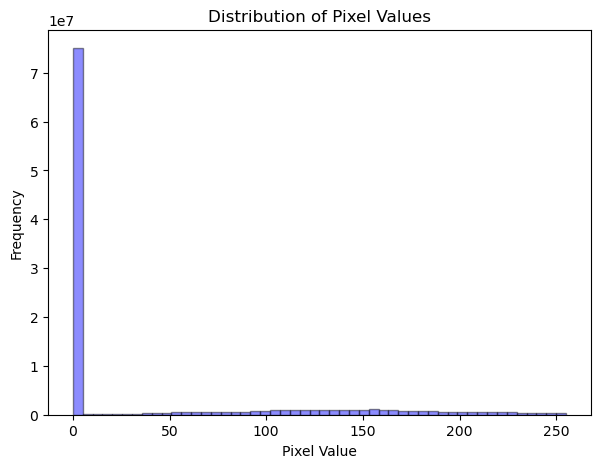

In [14]:
X_train = train_images.reshape(train_images.shape[0], -1)
pixel_values = X_train

plt.figure(figsize=(7, 5))
plt.hist(pixel_values.flatten(), edgecolor='k', color='b', alpha=0.45, bins=50)
# sns.histplot(pixel_values.flatten(), bins=50, kde=True)
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

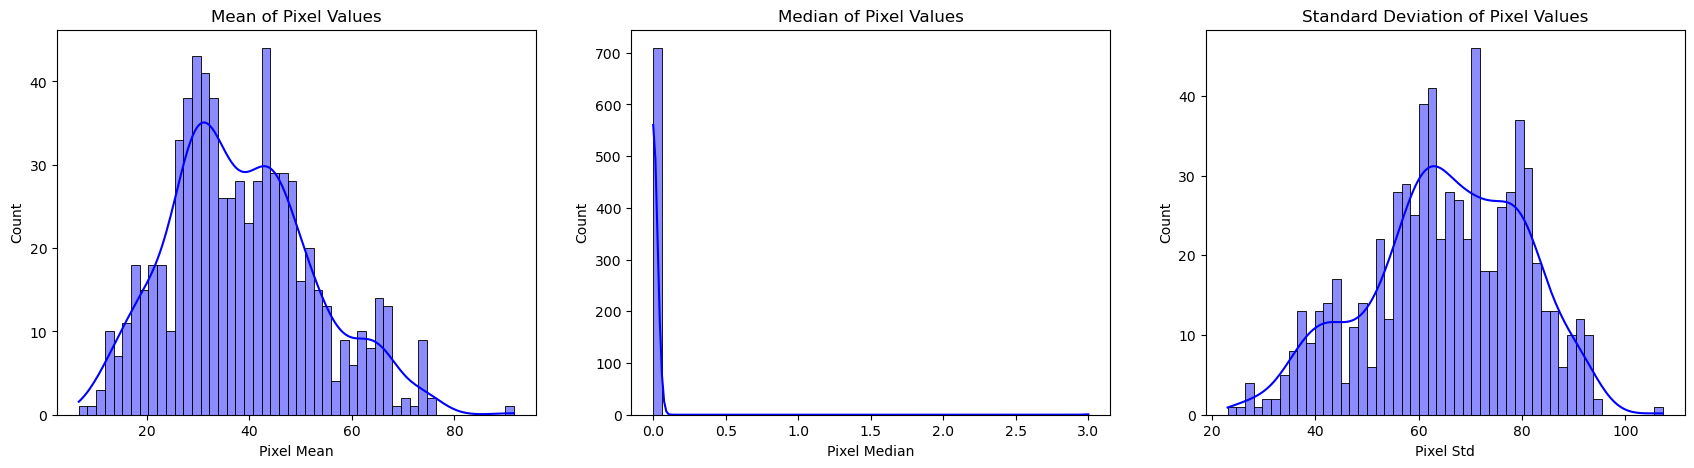

In [15]:
descriptive_stats_df = pd.DataFrame([])
pixel_mean = np.mean(pixel_values, axis=1)
pixel_median = np.median(pixel_values, axis=1)
pixel_std = np.std(pixel_values, axis=1)

descriptive_stats_df['Pixel Mean'] = pixel_mean
descriptive_stats_df['Pixel Median'] = pixel_median
descriptive_stats_df['Pixel Std'] = pixel_std

plt.figure(figsize=(21, 5))
plt.subplot(1, 3, 1)
sns.histplot(descriptive_stats_df['Pixel Mean'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Mean of Pixel Values')

plt.subplot(1, 3, 2)
sns.histplot(descriptive_stats_df['Pixel Median'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Median of Pixel Values')

plt.subplot(1, 3, 3)
sns.histplot(descriptive_stats_df['Pixel Std'], bins=50, color='b', alpha=0.45, kde=True)
plt.title('Standard Deviation of Pixel Values')

plt.show()

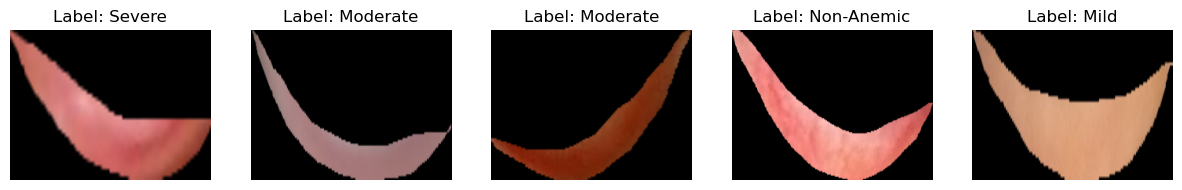

Some relations based on the images:
Image 167 has label: Severe
Image 538 has label: Moderate
Image 137 has label: Moderate
Image 436 has label: Non-Anemic
Image 544 has label: Mild


In [16]:
# Visualizing sample images and printing relations
num_samples = 5
sample_indices = random.sample(range(len(train_images)), num_samples)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(train_images[idx])
    plt.title(f"Label: {train_categories[idx]}")
    plt.axis('off')

plt.show()

# Print some relations based on the images (you can customize this based on your analysis)
print("Some relations based on the images:")
for idx in sample_indices:
    print(f"Image {idx} has label: {train_categories[idx]}")

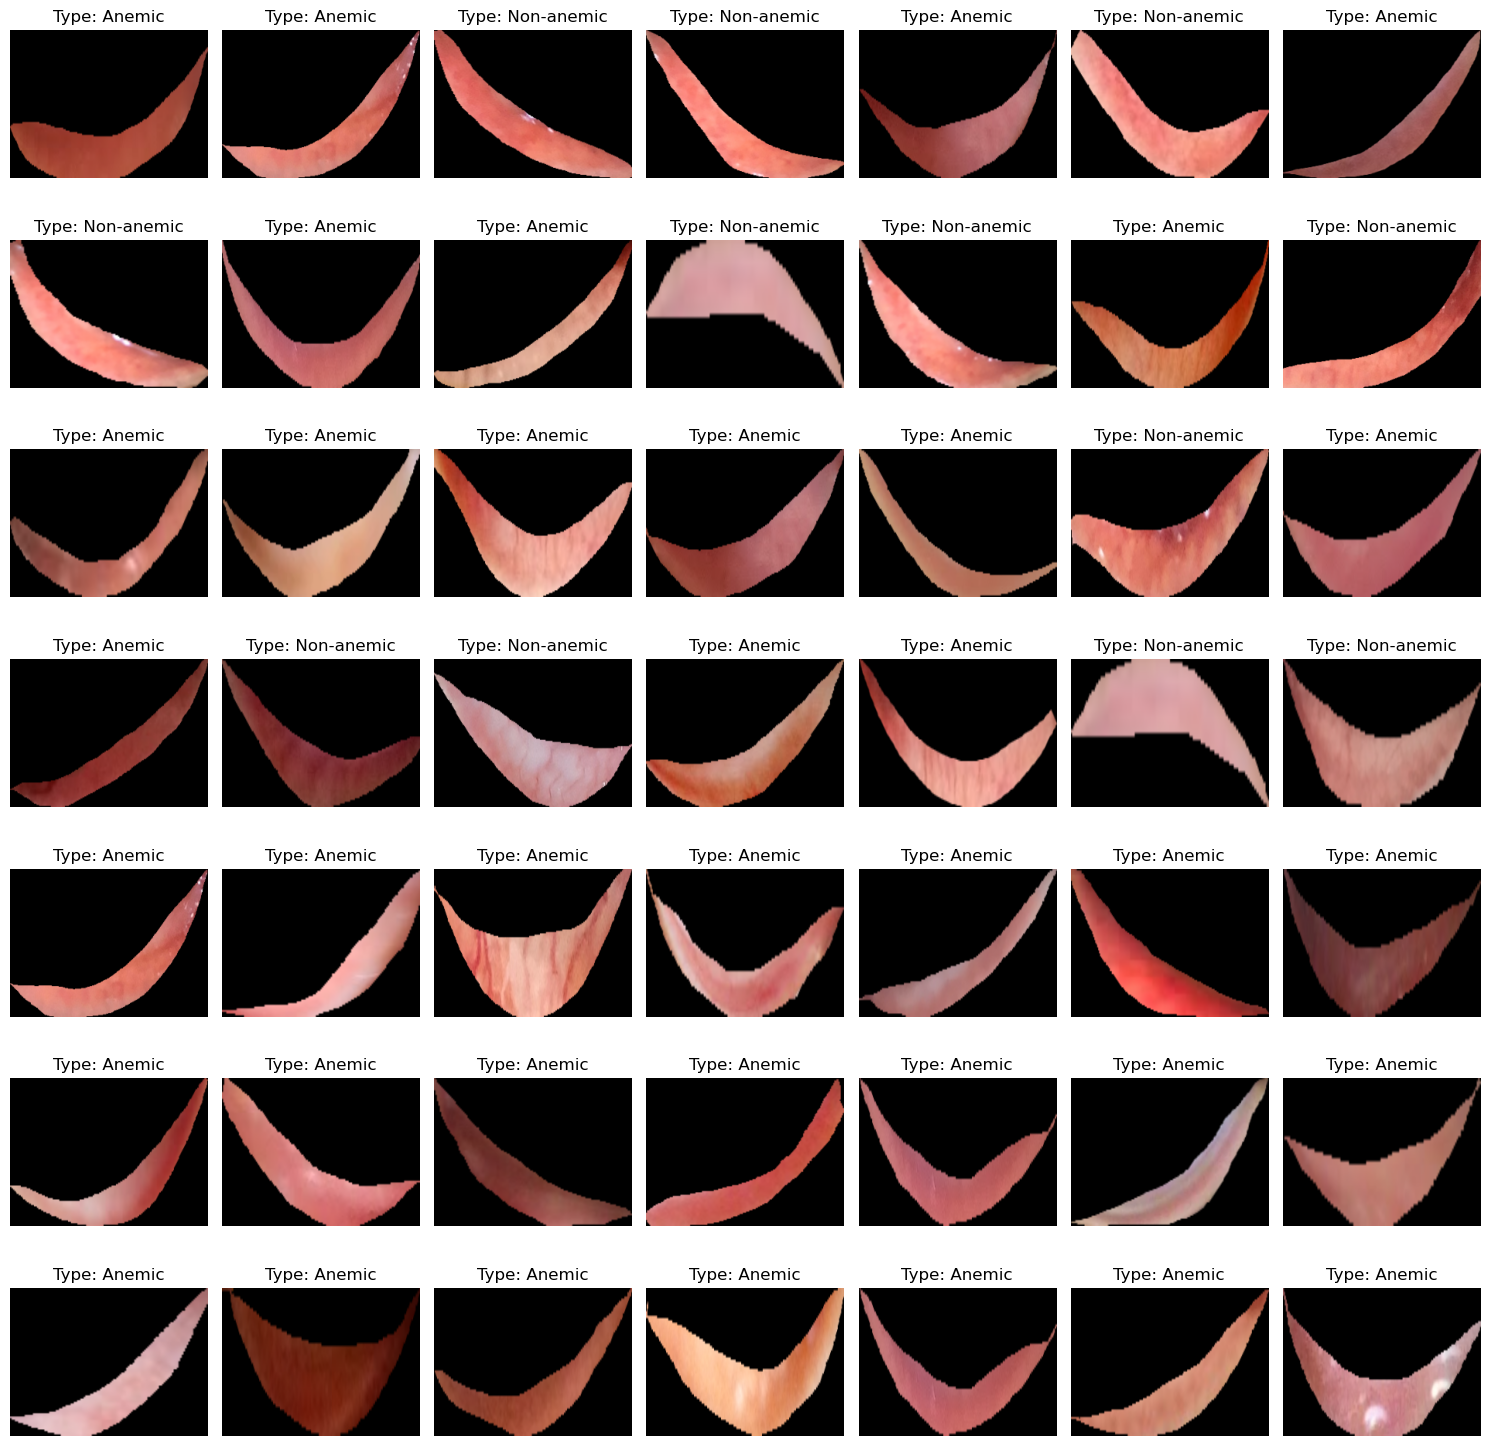

In [17]:
def plot_image_grid(df, dir, image_path, class_column, grid_size=(10, 10), image_size=(300, 300)):
    """
    Plots a grid of images from a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing image paths and their respective classes.
    image_column (str): Column name in the DataFrame that contains image paths.
    class_column (str): Column name in the DataFrame that contains image classes.
    grid_size (tuple): Size of the grid (rows, cols).
    image_size (tuple): Size to which each image will be resized (width, height).
    
    Returns:
    None
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    axes = axes.flatten()

    for i, (idx, row) in enumerate(df.iterrows()):
        if i >= grid_size[0] * grid_size[1]:
            break
        img_id = row[image_path]
        img_class = row[class_column]
        img_path = dir+"/"+img_class+"/"+img_id+".png"
        
        # Read and resize the image
        img = cv.imread(img_path)
        if img is None:
            print(f"Error loading image at {img_path}")
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, image_size)
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].set_title(f"Type: {img_class}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_image_grid(data_sheet, data_dir,
                image_path='IMAGE_ID',
                class_column='REMARK',
                grid_size=(7,7),
                image_size=(256,192))

In [18]:
device = torch.device('cpu')

# Default device
device = torch.device('cpu')

# Check for CUDA availability
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    print("CUDA is not available, using CPU.")

print(f"Selected device: {device}")

CUDA is not available, using CPU.
Selected device: cpu


In [18]:
# subset_length = round(len(data_sheet)*.10)
# # subset_length = round(25)
# print("Subset length:", subset_length)
# sample_df = data_sheet.sample(subset_length)
# display(sample_df)

In [19]:
# Define any data augmentations or transformations
transform = transforms.Compose([
    transforms.Resize((256,192)),
    # transforms.RandomHorizontalFlip(p=np.random.rand()),
    # transforms.RandomVerticalFlip(p=np.random.rand()),
    # transforms.RandomRotation(degrees=np.random.randint(0,360)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets from CSV files (assuming you have a custom dataset class)
class DRImageDataset(Dataset):
    def __init__(self, dir, df, transform=None):
        """
        Initializes the dataset with a directory and DataFrame, and optional transformations.
        
        Parameters:
        dir (str): Path to the directory containing images.
        df (DataFrame): DataFrame containing image IDs and labels.
        transform (callable, optional): Optional transformations to be applied to the images.
        """
        self.dir = dir
        self.df = df
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        
        Returns:
        int: Number of samples.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves the image and label at the specified index.
        
        Parameters:
        idx (int): Index of the sample to retrieve.
        
        Returns:
        tuple: (image, target, description) where image is the transformed image, target is the label, and description is the severity description.
        """
        row = self.df.iloc[idx]
        img_id = row['IMAGE_ID']
        img_folder = row['REMARK']
        img_path = os.path.join(self.dir, img_folder, img_id + ".png")
        # print(img_path)
        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor(row['REMARK_ONEHOT'], dtype=torch.int64)
        # print(img.size())
        # print(img)
        # print(label.size())
        # print(label)
        descriptor = img_folder
        
        return img, label, descriptor

# Create the dataset
image_dataset = DRImageDataset(data_dir, data_sheet, transform=transform)
# image_dataset = DRImageDataset(data_dir, sample_df, transform=transform)

# Split the dataset
train_dataset, test_dataset = train_test_split(image_dataset, test_size=0.3, shuffle=True)
val_dataset, test_dataset = train_test_split(test_dataset, test_size=0.5, shuffle=True)

print(f"Train Dataset: {len(train_dataset)}, Val Dataset: {len(val_dataset)}, Test Dataset: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=12, shuffle=False)

Train Dataset: 497, Val Dataset: 106, Test Dataset: 107


In [20]:
for img, label, desc in train_loader:
    print(img.shape)
    print(label.shape)
    print(desc)
    break

torch.Size([12, 3, 256, 192])
torch.Size([12])
('Anemic', 'Anemic', 'Anemic', 'Anemic', 'Anemic', 'Anemic', 'Non-anemic', 'Anemic', 'Anemic', 'Non-anemic', 'Non-anemic', 'Non-anemic')


In [21]:
def train(dataloader, model, loss_fn, optimizer, cumulative_metrics):
    """
    Training loop for one epoch.
    
    Parameters:
    dataloader (DataLoader): DataLoader containing the training data.
    model (torch.nn.Module): PyTorch model to be trained.
    loss_fn (callable): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
    cumulative_metrics (CumulativeMetrics): Instance of CumulativeMetrics for tracking metrics.
    
    Returns:
    tuple: Average loss and average accuracy for the epoch.
    """
    model.train()
    size = len(dataloader.dataset)
    batch_losses = []
    batch_acc = []
    cumulative_metrics.reset()

    for _, (X, y, _) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Training"):
        X, y = X.to(device), y.to(device).unsqueeze(1)
        y = y.to(torch.float32)
        
        optimizer.zero_grad()
        pred = model(X)

        # logits = model(X)
        # probabilities = torch.softmax(logits, dim=1) # Convert logits to probabilities using softmax
        # predicted_classes = torch.argmax(probabilities, dim=1) # Get the predicted class (index of the highest probability)
        # pred = torch.nn.functional.one_hot(predicted_classes, num_classes=5).float() # Convert class indices to one-hot encoding

        loss = loss_fn(pred, y)        
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())        
        cumulative_metrics.update(pred, y)
    
    avg_loss = sum(batch_losses) / len(batch_losses)    
    performance_metrics = cumulative_metrics.get_cumulative_metrics()

    return avg_loss, performance_metrics

def eval(dataloader, model, loss_fn, mode, cumulative_metrics):
    """
    Testing loop to evaluate the model on the test dataset.
    
    Parameters:
    dataloader (DataLoader): DataLoader containing the test data.
    model (torch.nn.Module): PyTorch model to be evaluated.
    loss_fn (callable): Loss function.
    cumulative_metrics (CumulativeMetrics): Instance of CumulativeMetrics for tracking metrics.
    
    Returns:
    tuple: Average loss and average accuracy for the test dataset.
    """
    model.eval()
    size = len(dataloader.dataset)
    batch_losses = []
    cumulative_metrics.reset()

    if mode == "Testing":
        with torch.no_grad():
            for _, (X, y, _) in enumerate(dataloader):
                X, y = X.to(device), y.to(device).unsqueeze(1)
                y = y.to(torch.float32)

                pred = model(X)
                # logits = model(X)
                # probabilities = torch.softmax(logits, dim=1) # Convert logits to probabilities using softmax
                # predicted_classes = torch.argmax(probabilities, dim=1) # Get the predicted class (index of the highest probability)
                # pred = torch.nn.functional.one_hot(predicted_classes, num_classes=5).float() # Convert class indices to one-hot encoding
                
                loss = loss_fn(pred, y)

                batch_losses.append(loss.item())
                cumulative_metrics.update(pred, y)
        
        avg_loss = sum(batch_losses) / len(batch_losses)    
        performance_metrics = cumulative_metrics.get_cumulative_metrics()

    
    if mode == "Validation":
        with torch.no_grad():
            for _, (X, y, _) in tqdm(enumerate(dataloader), total=len(dataloader), desc="Validation"):
                X, y = X.to(device), y.to(device).unsqueeze(1)
                y = y.to(torch.float32)

                pred = model(X)
                # logits = model(X)
                # probabilities = torch.softmax(logits, dim=1) # Convert logits to probabilities using softmax
                # predicted_classes = torch.argmax(probabilities, dim=1) # Get the predicted class (index of the highest probability)
                # pred = torch.nn.functional.one_hot(predicted_classes, num_classes=5).float() # Convert class indices to one-hot encoding
                
                loss = loss_fn(pred, y)

                batch_losses.append(loss.item())
                cumulative_metrics.update(pred, y)
        
        avg_loss = sum(batch_losses) / len(batch_losses)    
        performance_metrics = cumulative_metrics.get_cumulative_metrics()
    
    return avg_loss, performance_metrics

In [22]:
# Load MobileNetV2 with pretrained weights disabled
mbnetv2 = models.mobilenet_v2(weights=None)

# Modify the classifier to output 5 classes (corresponding to the severity levels)
mbnetv2.classifier[1] = torch.nn.Linear(in_features=1280, out_features=1)
mbnetv2 = mbnetv2.to(device)

# Print the model summary
print(summary(mbnetv2))

Layer (type:depth-idx)                             Param #
MobileNetV2                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            864
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─ReLU6: 3-3                             --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        896
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        5,136
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        8,832
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        10,000
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        14,848
│    └─InvertedResidual: 2-7                       --
│    │ 

In [23]:
class CumulativeMetrics:
    def __init__(self):
        # Initialize torchmetrics for binary classification
        self.accuracy = torchmetrics.Accuracy(task="binary").to(device)
        self.precision = torchmetrics.Precision(task="binary", average="macro").to(device)
        self.f1_score = torchmetrics.F1Score(task="binary", average="macro").to(device)

        # For scikit-learn metrics, we'll store the true and predicted values for each batch
        self.y_true_all = []
        self.y_pred_all = []
        self.y_score_all = []

        self.reset()

    def reset(self):
        # Reset torchmetrics accumulators
        self.cum_acc = 0.0
        self.cum_prec = 0.0
        self.cum_f1 = 0.0
        self.num_batches = 0
        
        # Reset true and predicted values lists for sklearn
        self.y_true_all = []
        self.y_pred_all = []
        self.y_score_all = []

    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        # For binary classification, y_true is already a class label (0 or 1)
        y_pred_class = torch.round(torch.sigmoid(y_pred)).int()  # Get predicted class by rounding sigmoid output

        # Append predictions and true labels for scikit-learn metrics later
        self.y_true_all.extend(y_true.cpu().numpy())
        self.y_pred_all.extend(y_pred_class.cpu().numpy())
        self.y_score_all.extend(torch.sigmoid(y_pred).detach().cpu().numpy())  # Probabilities/logits for AUC

        # Update cumulative torchmetrics
        acc = self.accuracy(y_pred_class, y_true).item()
        prec = self.precision(y_pred_class, y_true).item()
        f1 = self.f1_score(y_pred_class, y_true).item()

        self.cum_acc += acc
        self.cum_prec += prec
        self.cum_f1 += f1
        self.num_batches += 1

    def get_cumulative_metrics(self):
        avg_acc = self.cum_acc / self.num_batches
        avg_prec = self.cum_prec / self.num_batches
        avg_f1 = self.cum_f1 / self.num_batches

        performance_metrics =  {
            "Accuracy": avg_acc,
            "Precision": avg_prec,
            "F1 Score": avg_f1,
        }        
        return performance_metrics

In [25]:
# Initialize model, loss function, and optimizer
mbnetv2 = mbnetv2.to(device)

# Binary Cross Entropy with Logits Loss function
# Adam optimizer with a learning rate of 0.001
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mbnetv2.parameters(), lr=0.001)

# Number of epochs to train the model
EPOCHS = 25

# Lists to store the average loss and accuracy for each epoch
mbnetv2_train_epoch_losses = []
mbnetv2_train_epoch_acc = []

mbnetv2_val_epoch_losses = []
mbnetv2_val_epoch_acc = []

print(f"[ Started Training... ]")
for epoch in range(EPOCHS):
    print(f"\n[Epoch {epoch + 1}/{EPOCHS}] ")
    train_loss, train_performance_metrics =  train(train_loader, mbnetv2, loss_fn, optimizer, CumulativeMetrics())
    train_accuracy, train_precision, train_f1 = train_performance_metrics.values()
    print(f"Training: \tMSE Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Training: \tPrecision: {train_precision:.4f}, F1 Score: {train_f1:.4f}")

    val_loss, val_performance_metrics = eval(val_loader, mbnetv2, loss_fn, 'Validation', CumulativeMetrics())
    val_accuracy, val_precision, val_f1 = val_performance_metrics.values()
    print(f"Validation: \tMSE Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    print(f"Validation: \tPrecision: {val_precision:.4f}, F1 Score: {val_f1:.4f}")
    
    mbnetv2_train_epoch_losses.append(train_loss)
    mbnetv2_val_epoch_losses.append(val_loss)
    mbnetv2_train_epoch_acc.append(train_accuracy)
    mbnetv2_val_epoch_acc.append(val_accuracy)

print("\n[ Finished Training! ]")

[ Started Training... ]

[Epoch 1/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.73it/s]


Training: 	MSE Loss: 0.3044, Accuracy: 0.5817
Training: 	Precision: 0.5843, F1 Score: 0.7177


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.28it/s]


Validation: 	MSE Loss: 0.2862, Accuracy: 0.6204
Validation: 	Precision: 0.6162, F1 Score: 0.7509

[Epoch 2/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]


Training: 	MSE Loss: 0.2615, Accuracy: 0.6036
Training: 	Precision: 0.5990, F1 Score: 0.7353


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.37it/s]


Validation: 	MSE Loss: 0.3143, Accuracy: 0.5815
Validation: 	Precision: 0.5960, F1 Score: 0.7150

[Epoch 3/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]


Training: 	MSE Loss: 0.2149, Accuracy: 0.5980
Training: 	Precision: 0.5931, F1 Score: 0.7326


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.33it/s]


Validation: 	MSE Loss: 0.2437, Accuracy: 0.6019
Validation: 	Precision: 0.6019, F1 Score: 0.7452

[Epoch 4/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]


Training: 	MSE Loss: 0.1882, Accuracy: 0.6302
Training: 	Precision: 0.6150, F1 Score: 0.7521


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.84it/s]


Validation: 	MSE Loss: 0.2855, Accuracy: 0.6593
Validation: 	Precision: 0.6455, F1 Score: 0.7647

[Epoch 5/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]


Training: 	MSE Loss: 0.1516, Accuracy: 0.6421
Training: 	Precision: 0.6240, F1 Score: 0.7567


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.43it/s]


Validation: 	MSE Loss: 0.2318, Accuracy: 0.6685
Validation: 	Precision: 0.6462, F1 Score: 0.7743

[Epoch 6/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]


Training: 	MSE Loss: 0.1433, Accuracy: 0.6750
Training: 	Precision: 0.6510, F1 Score: 0.7753


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.25it/s]


Validation: 	MSE Loss: 0.2952, Accuracy: 0.7074
Validation: 	Precision: 0.6808, F1 Score: 0.7840

[Epoch 7/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]


Training: 	MSE Loss: 0.1470, Accuracy: 0.6456
Training: 	Precision: 0.6269, F1 Score: 0.7509


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.63it/s]


Validation: 	MSE Loss: 0.2510, Accuracy: 0.6296
Validation: 	Precision: 0.6204, F1 Score: 0.7542

[Epoch 8/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.63it/s]


Training: 	MSE Loss: 0.1333, Accuracy: 0.6877
Training: 	Precision: 0.6620, F1 Score: 0.7852


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.37it/s]


Validation: 	MSE Loss: 0.2227, Accuracy: 0.7463
Validation: 	Precision: 0.7041, F1 Score: 0.8163

[Epoch 9/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]


Training: 	MSE Loss: 0.1695, Accuracy: 0.7155
Training: 	Precision: 0.6972, F1 Score: 0.7975


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.91it/s]


Validation: 	MSE Loss: 0.2079, Accuracy: 0.6204
Validation: 	Precision: 0.6145, F1 Score: 0.7543

[Epoch 10/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]


Training: 	MSE Loss: 0.0864, Accuracy: 0.7008
Training: 	Precision: 0.6753, F1 Score: 0.7904


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.21it/s]


Validation: 	MSE Loss: 0.2016, Accuracy: 0.5926
Validation: 	Precision: 0.5976, F1 Score: 0.7327

[Epoch 11/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]


Training: 	MSE Loss: 0.0633, Accuracy: 0.7147
Training: 	Precision: 0.6879, F1 Score: 0.7992


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.01it/s]


Validation: 	MSE Loss: 0.1926, Accuracy: 0.6019
Validation: 	Precision: 0.6019, F1 Score: 0.7452

[Epoch 12/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.59it/s]


Training: 	MSE Loss: 0.0401, Accuracy: 0.7202
Training: 	Precision: 0.6950, F1 Score: 0.7982


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.29it/s]


Validation: 	MSE Loss: 0.1896, Accuracy: 0.6389
Validation: 	Precision: 0.6325, F1 Score: 0.7590

[Epoch 13/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.65it/s]


Training: 	MSE Loss: 0.0404, Accuracy: 0.7579
Training: 	Precision: 0.7311, F1 Score: 0.8248


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.47it/s]


Validation: 	MSE Loss: 0.1962, Accuracy: 0.6296
Validation: 	Precision: 0.6205, F1 Score: 0.7551

[Epoch 14/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]


Training: 	MSE Loss: 0.0307, Accuracy: 0.7290
Training: 	Precision: 0.6940, F1 Score: 0.8030


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.44it/s]


Validation: 	MSE Loss: 0.1810, Accuracy: 0.6481
Validation: 	Precision: 0.6313, F1 Score: 0.7677

[Epoch 15/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.68it/s]


Training: 	MSE Loss: 0.0368, Accuracy: 0.7440
Training: 	Precision: 0.7123, F1 Score: 0.8157


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.55it/s]


Validation: 	MSE Loss: 0.2391, Accuracy: 0.6296
Validation: 	Precision: 0.6384, F1 Score: 0.7358

[Epoch 16/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.69it/s]


Training: 	MSE Loss: 0.0325, Accuracy: 0.7643
Training: 	Precision: 0.7288, F1 Score: 0.8296


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.84it/s]


Validation: 	MSE Loss: 0.2025, Accuracy: 0.6019
Validation: 	Precision: 0.6019, F1 Score: 0.7452

[Epoch 17/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.69it/s]


Training: 	MSE Loss: 0.0189, Accuracy: 0.7353
Training: 	Precision: 0.7009, F1 Score: 0.8098


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.94it/s]


Validation: 	MSE Loss: 0.2068, Accuracy: 0.6574
Validation: 	Precision: 0.6508, F1 Score: 0.7671

[Epoch 18/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.72it/s]


Training: 	MSE Loss: 0.0311, Accuracy: 0.7536
Training: 	Precision: 0.7237, F1 Score: 0.8200


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.10it/s]


Validation: 	MSE Loss: 0.2080, Accuracy: 0.6111
Validation: 	Precision: 0.6094, F1 Score: 0.7499

[Epoch 19/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.71it/s]


Training: 	MSE Loss: 0.0174, Accuracy: 0.7591
Training: 	Precision: 0.7239, F1 Score: 0.8252


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.87it/s]


Validation: 	MSE Loss: 0.2155, Accuracy: 0.6481
Validation: 	Precision: 0.6340, F1 Score: 0.7644

[Epoch 20/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.71it/s]


Training: 	MSE Loss: 0.0178, Accuracy: 0.7552
Training: 	Precision: 0.7246, F1 Score: 0.8216


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.99it/s]


Validation: 	MSE Loss: 0.1869, Accuracy: 0.6481
Validation: 	Precision: 0.6394, F1 Score: 0.7628

[Epoch 21/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.67it/s]


Training: 	MSE Loss: 0.0126, Accuracy: 0.7492
Training: 	Precision: 0.7134, F1 Score: 0.8191


Validation: 100%|██████████| 9/9 [00:00<00:00, 14.97it/s]


Validation: 	MSE Loss: 0.1724, Accuracy: 0.6481
Validation: 	Precision: 0.6342, F1 Score: 0.7653

[Epoch 22/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.70it/s]


Training: 	MSE Loss: 0.0242, Accuracy: 0.7679
Training: 	Precision: 0.7318, F1 Score: 0.8314


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.74it/s]


Validation: 	MSE Loss: 0.2290, Accuracy: 0.6574
Validation: 	Precision: 0.6461, F1 Score: 0.7681

[Epoch 23/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]


Training: 	MSE Loss: 0.0534, Accuracy: 0.7095
Training: 	Precision: 0.6803, F1 Score: 0.7990


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.76it/s]


Validation: 	MSE Loss: 0.3056, Accuracy: 0.6907
Validation: 	Precision: 0.7144, F1 Score: 0.7552

[Epoch 24/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.58it/s]


Training: 	MSE Loss: 0.0704, Accuracy: 0.7155
Training: 	Precision: 0.6831, F1 Score: 0.7977


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.00it/s]


Validation: 	MSE Loss: 0.2110, Accuracy: 0.6019
Validation: 	Precision: 0.6019, F1 Score: 0.7452

[Epoch 25/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.62it/s]


Training: 	MSE Loss: 0.0804, Accuracy: 0.7115
Training: 	Precision: 0.6838, F1 Score: 0.7960


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.93it/s]

Validation: 	MSE Loss: 0.2373, Accuracy: 0.6111
Validation: 	Precision: 0.6069, F1 Score: 0.7495

[ Finished Training! ]


In [26]:
test_loss, test_performance_metrics = eval(test_loader, mbnetv2, loss_fn, 'Testing', CumulativeMetrics())
test_accuracy, test_precision, test_f1 = test_performance_metrics.values()
print(f"Testing: \tMSE Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
print(f"Testing: \tPrecision: {test_precision:.4f}, F1 Score: {test_f1:.4f}")

Testing: 	MSE Loss: 0.2213, Accuracy: 0.6338
Testing: 	Precision: 0.6338, F1 Score: 0.7708


In [27]:
# Load MobileNetV2 with pretrained weights disabled
mbnetv2_pretrained = models.mobilenet_v2(weights="IMAGENET1K_V2")

# Modify the classifier to output 5 classes (corresponding to the severity levels)
mbnetv2_pretrained.classifier[1] = torch.nn.Linear(in_features=1280, out_features=1)
mbnetv2_pretrained = mbnetv2_pretrained.to(device)

# Print the model summary
print(summary(mbnetv2_pretrained))

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\sebastian.cruz6/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 26.6MB/s]

Layer (type:depth-idx)                             Param #
MobileNetV2                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            864
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─ReLU6: 3-3                             --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        896
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        5,136
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        8,832
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        10,000
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        14,848
│    └─InvertedResidual: 2-7                       --
│    │ 

In [28]:
pretrained_test_loss, pretrained_test_performance_metrics = eval(test_loader, mbnetv2_pretrained, loss_fn, 'Testing', CumulativeMetrics())
pretrained_test_accuracy, pretrained_test_precision, pretrained_test_f1 = pretrained_test_performance_metrics.values()
print(f"Testing: \tMSE Loss: {pretrained_test_loss:.4f}, Accuracy: {pretrained_test_accuracy:.4f}")
print(f"Testing: \tPrecision: {pretrained_test_precision:.4f}, F1 Score: {pretrained_test_f1:.4f}")

Testing: 	MSE Loss: 0.7372, Accuracy: 0.4133
Testing: 	Precision: 0.6204, F1 Score: 0.3146


In [29]:
# Load MobileNetV2 with pretrained weights disabled
mbnetv2_pretrained_more = models.mobilenet_v2(weights="IMAGENET1K_V2")

# Modify the classifier to output 5 classes (corresponding to the severity levels)
mbnetv2_pretrained_more.classifier[1] = torch.nn.Linear(in_features=1280, out_features=1)
mbnetv2_pretrained_more = mbnetv2_pretrained_more.to(device)

# Print the model summary
print(summary(mbnetv2_pretrained_more))

Layer (type:depth-idx)                             Param #
MobileNetV2                                        --
├─Sequential: 1-1                                  --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            864
│    │    └─BatchNorm2d: 3-2                       64
│    │    └─ReLU6: 3-3                             --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        896
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        5,136
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        8,832
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        10,000
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        14,848
│    └─InvertedResidual: 2-7                       --
│    │ 

In [30]:
# Initialize model, loss function, and optimizer
mbnetv2_pretrained_more = mbnetv2_pretrained_more.to(device)

# Binary Cross Entropy with Logits Loss function
# Adam optimizer with a learning rate of 0.001
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()
optimizer_pretrained_more = torch.optim.Adam(mbnetv2_pretrained_more.parameters(), lr=0.001)

# Number of epochs to train the model
EPOCHS = 25

# Lists to store the average loss and accuracy for each epoch
pretrained_more_mbnetv2_train_epoch_losses = []
pretrained_more_mbnetv2_train_epoch_acc = []

pretrained_more_mbnetv2_val_epoch_losses = []
pretrained_more_mbnetv2_val_epoch_acc = []

print(f"[ Started Training... ]")
for epoch in range(EPOCHS):
    print(f"\n[Epoch {epoch + 1}/{EPOCHS}] ")
    pretrained_more_train_loss, pretrained_more_train_performance_metrics =  train(train_loader, mbnetv2_pretrained_more, loss_fn, optimizer_pretrained_more, CumulativeMetrics())
    pretrained_more_train_accuracy, pretrained_more_train_precision, pretrained_more_train_f1 = pretrained_more_train_performance_metrics.values()
    print(f"Training: \tMSE Loss: {pretrained_more_train_loss:.4f}, Accuracy: {pretrained_more_train_accuracy:.4f}")
    print(f"Training: \tPrecision: {pretrained_more_train_precision:.4f}, F1 Score: {pretrained_more_train_f1:.4f}")

    pretrained_more_val_loss, pretrained_more_val_performance_metrics = eval(val_loader, mbnetv2_pretrained_more, loss_fn, 'Validation', CumulativeMetrics())
    pretrained_more_val_accuracy, pretrained_more_val_precision, pretrained_more_val_f1 = pretrained_more_val_performance_metrics.values()
    print(f"Validation: \tMSE Loss: {pretrained_more_val_loss:.4f}, Accuracy: {pretrained_more_val_accuracy:.4f}")
    print(f"Validation: \tPrecision: {pretrained_more_val_precision:.4f}, F1 Score: {pretrained_more_val_f1:.4f}")
    
    pretrained_more_mbnetv2_train_epoch_losses.append(train_loss)
    pretrained_more_mbnetv2_val_epoch_losses.append(val_loss)
    pretrained_more_mbnetv2_train_epoch_acc.append(train_accuracy)
    pretrained_more_mbnetv2_val_epoch_acc.append(val_accuracy)

print("\n[ Finished Training! ]")

[ Started Training... ]

[Epoch 1/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.61it/s]


Training: 	MSE Loss: 0.2486, Accuracy: 0.6095
Training: 	Precision: 0.5929, F1 Score: 0.7292


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.18it/s]


Validation: 	MSE Loss: 0.2399, Accuracy: 0.6019
Validation: 	Precision: 0.6019, F1 Score: 0.7452

[Epoch 2/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.68it/s]


Training: 	MSE Loss: 0.1659, Accuracy: 0.6234
Training: 	Precision: 0.6098, F1 Score: 0.7483


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.99it/s]


Validation: 	MSE Loss: 0.2132, Accuracy: 0.6019
Validation: 	Precision: 0.6019, F1 Score: 0.7452

[Epoch 3/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.79it/s]


Training: 	MSE Loss: 0.1242, Accuracy: 0.6413
Training: 	Precision: 0.6252, F1 Score: 0.7583


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.31it/s]


Validation: 	MSE Loss: 0.2123, Accuracy: 0.7222
Validation: 	Precision: 0.7010, F1 Score: 0.8116

[Epoch 4/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.78it/s]


Training: 	MSE Loss: 0.0897, Accuracy: 0.6885
Training: 	Precision: 0.6553, F1 Score: 0.7808


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.53it/s]


Validation: 	MSE Loss: 0.2082, Accuracy: 0.7037
Validation: 	Precision: 0.6727, F1 Score: 0.7968

[Epoch 5/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.78it/s]


Training: 	MSE Loss: 0.0680, Accuracy: 0.6778
Training: 	Precision: 0.6551, F1 Score: 0.7770


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.98it/s]


Validation: 	MSE Loss: 0.1634, Accuracy: 0.7037
Validation: 	Precision: 0.6712, F1 Score: 0.7973

[Epoch 6/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.81it/s]


Training: 	MSE Loss: 0.0525, Accuracy: 0.7115
Training: 	Precision: 0.6848, F1 Score: 0.7965


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.89it/s]


Validation: 	MSE Loss: 0.1665, Accuracy: 0.7037
Validation: 	Precision: 0.6710, F1 Score: 0.7970

[Epoch 7/25] 


Training: 100%|██████████| 42/42 [00:10<00:00,  3.82it/s]


Training: 	MSE Loss: 0.0403, Accuracy: 0.7143
Training: 	Precision: 0.6832, F1 Score: 0.7905


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.64it/s]


Validation: 	MSE Loss: 0.1648, Accuracy: 0.6481
Validation: 	Precision: 0.6330, F1 Score: 0.7679

[Epoch 8/25] 


Training: 100%|██████████| 42/42 [00:10<00:00,  3.83it/s]


Training: 	MSE Loss: 0.0445, Accuracy: 0.7194
Training: 	Precision: 0.6843, F1 Score: 0.8042


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.98it/s]


Validation: 	MSE Loss: 0.2053, Accuracy: 0.6481
Validation: 	Precision: 0.6354, F1 Score: 0.7662

[Epoch 9/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.81it/s]


Training: 	MSE Loss: 0.0495, Accuracy: 0.7008
Training: 	Precision: 0.6709, F1 Score: 0.7868


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.89it/s]


Validation: 	MSE Loss: 0.1627, Accuracy: 0.6667
Validation: 	Precision: 0.6495, F1 Score: 0.7761

[Epoch 10/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.76it/s]


Training: 	MSE Loss: 0.0466, Accuracy: 0.7298
Training: 	Precision: 0.6932, F1 Score: 0.8056


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.43it/s]


Validation: 	MSE Loss: 0.1837, Accuracy: 0.6667
Validation: 	Precision: 0.6453, F1 Score: 0.7778

[Epoch 11/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.72it/s]


Training: 	MSE Loss: 0.0494, Accuracy: 0.7306
Training: 	Precision: 0.7015, F1 Score: 0.8091


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.36it/s]


Validation: 	MSE Loss: 0.1529, Accuracy: 0.6574
Validation: 	Precision: 0.6439, F1 Score: 0.7714

[Epoch 12/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.78it/s]


Training: 	MSE Loss: 0.0439, Accuracy: 0.7202
Training: 	Precision: 0.6889, F1 Score: 0.7965


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.87it/s]


Validation: 	MSE Loss: 0.1293, Accuracy: 0.6852
Validation: 	Precision: 0.6675, F1 Score: 0.7880

[Epoch 13/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.79it/s]


Training: 	MSE Loss: 0.0308, Accuracy: 0.7159
Training: 	Precision: 0.6861, F1 Score: 0.7964


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.39it/s]


Validation: 	MSE Loss: 0.1805, Accuracy: 0.7037
Validation: 	Precision: 0.6761, F1 Score: 0.7956

[Epoch 14/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.78it/s]


Training: 	MSE Loss: 0.0342, Accuracy: 0.7409
Training: 	Precision: 0.7060, F1 Score: 0.8095


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.05it/s]


Validation: 	MSE Loss: 0.1585, Accuracy: 0.6481
Validation: 	Precision: 0.6345, F1 Score: 0.7660

[Epoch 15/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.77it/s]


Training: 	MSE Loss: 0.0313, Accuracy: 0.7365
Training: 	Precision: 0.7023, F1 Score: 0.8091


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.14it/s]


Validation: 	MSE Loss: 0.1557, Accuracy: 0.7037
Validation: 	Precision: 0.6697, F1 Score: 0.7963

[Epoch 16/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.72it/s]


Training: 	MSE Loss: 0.0252, Accuracy: 0.7619
Training: 	Precision: 0.7297, F1 Score: 0.8248


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.44it/s]


Validation: 	MSE Loss: 0.1531, Accuracy: 0.6759
Validation: 	Precision: 0.6500, F1 Score: 0.7829

[Epoch 17/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.69it/s]


Training: 	MSE Loss: 0.0164, Accuracy: 0.7504
Training: 	Precision: 0.7119, F1 Score: 0.8214


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.85it/s]


Validation: 	MSE Loss: 0.1364, Accuracy: 0.6667
Validation: 	Precision: 0.6490, F1 Score: 0.7802

[Epoch 18/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.77it/s]


Training: 	MSE Loss: 0.0200, Accuracy: 0.7587
Training: 	Precision: 0.7183, F1 Score: 0.8169


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.39it/s]


Validation: 	MSE Loss: 0.1474, Accuracy: 0.6296
Validation: 	Precision: 0.6204, F1 Score: 0.7588

[Epoch 19/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.73it/s]


Training: 	MSE Loss: 0.0143, Accuracy: 0.7722
Training: 	Precision: 0.7283, F1 Score: 0.8322


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.92it/s]


Validation: 	MSE Loss: 0.1478, Accuracy: 0.6389
Validation: 	Precision: 0.6263, F1 Score: 0.7634

[Epoch 20/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.70it/s]


Training: 	MSE Loss: 0.0177, Accuracy: 0.7607
Training: 	Precision: 0.7184, F1 Score: 0.8181


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.90it/s]


Validation: 	MSE Loss: 0.1482, Accuracy: 0.6481
Validation: 	Precision: 0.6298, F1 Score: 0.7679

[Epoch 21/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.81it/s]


Training: 	MSE Loss: 0.0192, Accuracy: 0.7802
Training: 	Precision: 0.7357, F1 Score: 0.8301


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.97it/s]


Validation: 	MSE Loss: 0.1474, Accuracy: 0.6481
Validation: 	Precision: 0.6313, F1 Score: 0.7677

[Epoch 22/25] 


Training: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]


Training: 	MSE Loss: 0.0171, Accuracy: 0.7607
Training: 	Precision: 0.7141, F1 Score: 0.8193


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.54it/s]


Validation: 	MSE Loss: 0.1624, Accuracy: 0.6204
Validation: 	Precision: 0.6128, F1 Score: 0.7541

[Epoch 23/25] 


Training: 100%|██████████| 42/42 [00:10<00:00,  3.82it/s]


Training: 	MSE Loss: 0.0252, Accuracy: 0.7643
Training: 	Precision: 0.7223, F1 Score: 0.8277


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.40it/s]


Validation: 	MSE Loss: 0.1460, Accuracy: 0.7037
Validation: 	Precision: 0.6697, F1 Score: 0.7963

[Epoch 24/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.60it/s]


Training: 	MSE Loss: 0.0169, Accuracy: 0.7583
Training: 	Precision: 0.7146, F1 Score: 0.8226


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.71it/s]


Validation: 	MSE Loss: 0.1547, Accuracy: 0.6296
Validation: 	Precision: 0.6195, F1 Score: 0.7587

[Epoch 25/25] 


Training: 100%|██████████| 42/42 [00:11<00:00,  3.66it/s]


Training: 	MSE Loss: 0.0171, Accuracy: 0.7540
Training: 	Precision: 0.7177, F1 Score: 0.8232


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.96it/s]

Validation: 	MSE Loss: 0.1501, Accuracy: 0.7315
Validation: 	Precision: 0.6966, F1 Score: 0.8111

[ Finished Training! ]


In [31]:
pretrained_more_test_loss, pretrained_more_test_performance_metrics = eval(test_loader, mbnetv2_pretrained_more, loss_fn, 'Testing', CumulativeMetrics())
pretrained_more_test_accuracy, pretrained_more_test_precision, pretrained_more_test_f1 = pretrained_more_test_performance_metrics.values()
print(f"Testing: \tMSE Loss: {pretrained_more_test_loss:.4f}, Accuracy: {pretrained_more_test_accuracy:.4f}")
print(f"Testing: \tPrecision: {pretrained_more_test_precision:.4f}, F1 Score: {pretrained_more_test_f1:.4f}")

Testing: 	MSE Loss: 0.1760, Accuracy: 0.7652
Testing: 	Precision: 0.7333, F1 Score: 0.8363


In [34]:
def print_model_size(title, mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print(title, "%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [36]:
"""
mbnetv2_pretrained_more
mbnetv2_pretrained
mbnetv2
"""

print_model_size("MobileNetV2 w/o Pre-trained Weights Trained on CP-AnemiC Dataset:", mbnetv2)
print_model_size("MobileNetV2 w/ Pre-trained Weights (ImageNet1K):", mbnetv2_pretrained)
print_model_size("MobileNetV2 without Pre-trained Weights (ImageNet1K) Trained on CP-AnemiC Dataset:", mbnetv2_pretrained_more)

MobileNetV2 w/o Pre-trained Weights Trained on CP-AnemiC Dataset: 9.12 MB
MobileNetV2 w/ Pre-trained Weights (ImageNet1K): 9.12 MB
MobileNetV2 without Pre-trained Weights (ImageNet1K) Trained on CP-AnemiC Dataset: 9.12 MB
